## Preprocess the clinical dataset

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.utils import compute_class_weight

The clinical data can be obtained by viewing one's cart on the GDC client, and selecting the "Clinical" download icon. The downloaded folder contains three .tsv files, one of which is "clinical.tsv". First, define the path to our clinical data and where to store our processed dataset.

In [2]:
CLINICAL_DATA_PATH = "/users/anair27/data/anair27/data_original/clinical.tsv"
DESTINATION_DATA_PATH = "/users/anair27/data/TCGA_Data/project_LUAD/data_processed/PRCSD_clinical_data.csv"
DESTINATION_NO_TARGET_DATA_PATH = "/users/anair27/data/TCGA_Data/project_LUAD/data_processed/PRCSD_clinical_data_no_target.csv"

Next, read the data and drop any duplicate cases that may appear.

In [3]:
clinical_data_raw = pd.read_csv(CLINICAL_DATA_PATH, sep = '\t')
clinical_data_raw = clinical_data_raw.drop_duplicates(subset='case_submitter_id', keep="last")

The target variable, **vital_status**, is a binary class. Oftentimes, there is a class imbalance issue. This issue will be addressed using class rebalancing strategies at a later stage in preprocessing, once data modalities have been concatenated.

In [4]:
clinical_data_raw['vital_status'].value_counts()

Alive    334
Dead     188
Name: vital_status, dtype: int64

Here are two important variables we are considering. Sometimes, reading the CSVs lead to notation errors for NAs. These should be corrected for.

In [5]:
clinical_data_raw[['days_to_death', 'vital_status']]

days_to_death vital_status
1              '--        Alive
3              '--        Alive
5              '--        Alive
7              557         Dead
9              '--        Alive
...            ...          ...
1035           '--        Alive
1037           '--        Alive
1039           154         Dead
1041           '--        Alive
1043           385         Dead

[522 rows x 2 columns]

In [6]:
# fill in NAs for extraneous values
clinical_data_nas=clinical_data_raw.mask(clinical_data_raw == '\'--')

Next, we filter out any variables that have missing values.

In [7]:
# filter out columns that have NAs
clinical_data_no_nas = clinical_data_nas.loc[:, ~clinical_data_nas.isnull().any()].reset_index(drop = True)
clinical_data_no_nas.head()

case_id case_submitter_id project_id  \
0  18478121-f1d1-4bdd-9511-8ab22f4a0660      TCGA-78-8640  TCGA-LUAD   
1  9b4eeecb-6aff-435b-a244-ec362af92b7f      TCGA-05-5425  TCGA-LUAD   
2  dd46c83e-6551-485b-b935-f3beed891244      TCGA-55-7815  TCGA-LUAD   
3  cbfef004-b437-4d51-9d88-a2db50aa6481      TCGA-44-7661  TCGA-LUAD   
4  a9644274-13bb-4228-9b4f-14260ccc26eb      TCGA-97-7554  TCGA-LUAD   

                ethnicity  gender          race vital_status  \
0            not reported    male  not reported        Alive   
1            not reported    male  not reported        Alive   
2            not reported    male  not reported        Alive   
3  not hispanic or latino  female         white         Dead   
4  not hispanic or latino  female         white        Alive   

  ajcc_pathologic_t classification_of_tumor icd_10_code  ...  \
0                T1            not reported       C34.1  ...   
1               T2b            not reported       C34.9  ...   
2               T2a            not reported       C34.3  ...   
3               T2a            not reported       C34.3  ...   
4               T2a            not reported       C34.3  ...   

                    primary_diagnosis prior_malignancy prior_treatment  \
0                 Adenocarcinoma, NOS               no              No   
1  Adenocarcinoma with mixed subtypes               no              No   
2                 Adenocarcinoma, NOS               no              No   
3                 Adenocarcinoma, NOS              yes              No   
4       Papillary adenocarcinoma, NOS               no              No   

  progression_or_recurrence site_of_resection_or_biopsy  \
0              not reported            Upper lobe, lung   
1              not reported                   Lung, NOS   
2              not reported            Lower lobe, lung   
3              not reported            Lower lobe, lung   
4              not reported            Lower lobe, lung   

  synchronous_malignancy tissue_or_organ_of_origin   tumor_grade  \
0                     No          Upper lobe, lung  not reported   
1                     No                 Lung, NOS  not reported   
2                     No          Lower lobe, lung  not reported   
3           Not Reported          Lower lobe, lung  not reported   
4                     No          Lower lobe, lung  not reported   

  treatment_or_therapy               treatment_type  
0                   no       Radiation Therapy, NOS  
1                  yes  Pharmaceutical Therapy, NOS  
2                  yes  Pharmaceutical Therapy, NOS  
3                  yes       Radiation Therapy, NOS  
4                  yes  Pharmaceutical Therapy, NOS  

[5 rows x 22 columns]

There are still several features that have very little variation (same labels across most cases). We can determine coefficients of variation for the categorical features to determine ones that may be more informative for analysis.

<BarContainer object of 22 artists>

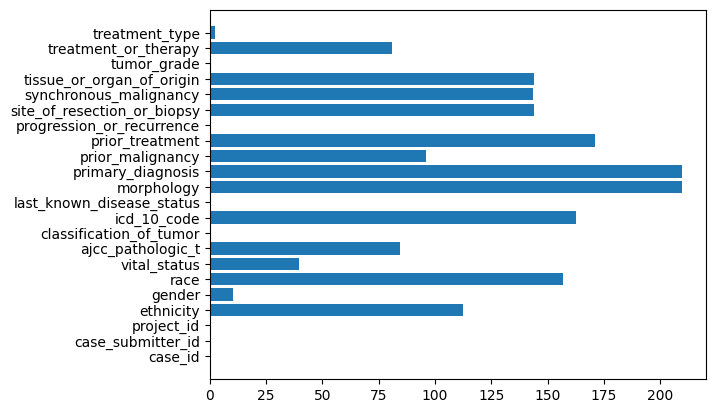

In [8]:
cvs = {}
for column in clinical_data_no_nas.columns:
    if clinical_data_no_nas[column].dtype == 'object':
        frequencies = clinical_data_no_nas[column].value_counts()
        std_dev = frequencies.std()
        mean = frequencies.mean()
        CV = (std_dev / mean) * 100
        cvs[column] = CV
plt.barh(range(len(cvs)), list(cvs.values()), tick_label=list(cvs.keys()))

We can determine a specific threshold (here it is 70) to isolate highly variable features.

In [9]:
hv_features = []
for var in cvs:
    if cvs[var] > 70:
        hv_features.append(var)
print(hv_features)

['ethnicity', 'race', 'ajcc_pathologic_t', 'icd_10_code', 'morphology', 'primary_diagnosis', 'prior_malignancy', 'prior_treatment', 'site_of_resection_or_biopsy', 'synchronous_malignancy', 'tissue_or_organ_of_origin', 'treatment_or_therapy']


Next, we convert the categorical variables into dummy variables to represent them numerically.

In [10]:
categorical = ["vital_status"] + hv_features

In [11]:
dfs = []
for col in categorical:
    dfs.append(pd.get_dummies(clinical_data_no_nas[col], prefix = col, drop_first = True))
categorical_dummies = pd.concat(dfs, axis = 1)
categorical_dummies

vital_status_Dead  ethnicity_not hispanic or latino  \
0                    0                                 0   
1                    0                                 0   
2                    0                                 0   
3                    1                                 1   
4                    0                                 1   
..                 ...                               ...   
517                  0                                 0   
518                  0                                 1   
519                  1                                 1   
520                  0                                 1   
521                  1                                 1   

     ethnicity_not reported  race_asian  race_black or african american  \
0                         1           0                               0   
1                         1           0                               0   
2                         1           0                               0   
3                         0           0                               0   
4                         0           0                               0   
..                      ...         ...                             ...   
517                       1           0                               0   
518                       0           0                               0   
519                       0           0                               0   
520                       0           0                               0   
521                       0           0                               0   

     race_not reported  race_white  ajcc_pathologic_t_T1a  \
0                    1           0                      0   
1                    1           0                      0   
2                    1           0                      0   
3                    0           1                      0   
4                    0           1                      0   
..                 ...         ...                    ...   
517                  1           0                      0   
518                  0           1                      0   
519                  0           1                      0   
520                  0           1                      0   
521                  0           1                      0   

     ajcc_pathologic_t_T1b  ajcc_pathologic_t_T2  ...  \
0                        0                     0  ...   
1                        0                     0  ...   
2                        0                     0  ...   
3                        0                     0  ...   
4                        0                     0  ...   
..                     ...                   ...  ...   
517                      0                     1  ...   
518                      0                     0  ...   
519                      0                     0  ...   
520                      1                     0  ...   
521                      0                     0  ...   

     site_of_resection_or_biopsy_Upper lobe, lung  \
0                                               1   
1                                               0   
2                                               0   
3                                               0   
4                                               0   
..                                            ...   
517                                             1   
518                                             1   
519                                             1   
520                                             1   
521                                             1   

     synchronous_malignancy_Not Reported  synchronous_malignancy_Yes  \
0                                      0                           0   
1                                      0                           0   
2                                      0                           0   
3                                      1

In [12]:
# Attach the case ID as a feature
c_data = categorical_dummies.assign(case_id=clinical_data_no_nas["case_submitter_id"])
c_data.head()

vital_status_Dead  ethnicity_not hispanic or latino  \
0                  0                                 0   
1                  0                                 0   
2                  0                                 0   
3                  1                                 1   
4                  0                                 1   

   ethnicity_not reported  race_asian  race_black or african american  \
0                       1           0                               0   
1                       1           0                               0   
2                       1           0                               0   
3                       0           0                               0   
4                       0           0                               0   

   race_not reported  race_white  ajcc_pathologic_t_T1a  \
0                  1           0                      0   
1                  1           0                      0   
2                  1           0                      0   
3                  0           1                      0   
4                  0           1                      0   

   ajcc_pathologic_t_T1b  ajcc_pathologic_t_T2  ...  \
0                      0                     0  ...   
1                      0                     0  ...   
2                      0                     0  ...   
3                      0                     0  ...   
4                      0                     0  ...   

   synchronous_malignancy_Not Reported  synchronous_malignancy_Yes  \
0                                    0                           0   
1                                    0                           0   
2                                    0                           0   
3                                    1                           0   
4                                    0                           0   

   tissue_or_organ_of_origin_Lung, NOS  \
0                                    0   
1                                    1   
2                                    0   
3                                    0   
4                                    0   

   tissue_or_organ_of_origin_Main bronchus  \
0                                        0   
1                                        0   
2                                        0   
3                                        0   
4                                        0   

   tissue_or_organ_of_origin_Middle lobe, lung  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   

   tissue_or_organ_of_origin_Overlapping lesion of lung  \
0                                                  0      
1                                                  0      
2                                                  0      
3                                                  0      
4                                                  0      

   tissue_or_organ_of_origin_Upper lobe, lung  \
0                                           1   
1                                           0   
2                                           0   
3                                           0   
4                                           0   

   treatment_or_therapy_not reported  treatment_or_therapy_yes       case_id  
0                                  0                         0  TCGA-78-8640  
1                                  0                         1  TCGA-05-5425  
2                                  0                         1  TCGA-55-7815  
3                                  0                         1  TCGA-44-7661  
4                                  0                         1  TCGA-97-7554  

[5 rows x 61 columns]

Save the processed clinical data!

In [13]:
c_data.to_csv(DESTINATION_DATA_PATH)

In [14]:
clinical_data = c_data.loc[:, c_data.columns != 'vital_status_Dead']
clinical_data.to_csv(DESTINATION_NO_TARGET_DATA_PATH)

---